<a href="https://colab.research.google.com/github/Shazzad0407/Mental-Health-CGPA-Prediction-Using-Machine-Learning/blob/master/MentalHealthWordEmbeddingFinalVersion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip uninstall tensorflow-gpu  #(run only once)

In [0]:
#for elmo word embedding (run only once)
!pip install tensorflow-hub
!pip install --upgrade tensorflow-gpu
# For the latest nightly build:
!pip install tf-nightly


     |████████████████████████████████| 377.0MB 113kB/s 
     |████████████████████████████████| 110.8MB 83.2MB/s 
     |████████████████████████████████| 3.8MB 26.3MB/s 
     |████████████████████████████████| 512kB 55.6MB/s 
     |████████████████████████████████| 71kB 24.1MB/s 
  Created wheel for opt-einsum: filename=opt_einsum-3.0.1-cp36-none-any.whl size=58500 sha256=3947745af966b2ba9b30dacf304db3d836715f4112056fdf4209bc043b02e4aa
  Stored in directory: /root/.cache/pip/wheels/91/98/8d/10e3d4e04c959597a411b91acd3695e9e2d210e68ce3427aad
Successfully built opt-einsum


In [0]:
#mount google drive
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
#change directory 
cd drive/My Drive

/content/drive/My Drive


# **Import necessary libray and Data**

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import numpy as np
import spacy
import random
from sklearn.model_selection import train_test_split
from scipy.spatial.distance import cdist

# from tf.keras.models import Sequential  # This does not work!
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, GRU, Embedding, Dropout, LSTM, Bidirectional,TimeDistributed
from tensorflow.python.keras.optimizers import Adam
from tensorflow.python.keras.optimizers import SGD
from tensorflow.python.keras.preprocessing.text import Tokenizer
from tensorflow.python.keras.preprocessing.sequence import pad_sequences

#for encoding
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils

Using TensorFlow backend.


In [0]:
url ='mentalHealthAllData.csv'
df = pd.read_csv(url,encoding='latin1')     #read data from the link
df.head()

,Student id,DI,PSS,GSE,Ex,A,C,E,O,CGPA,Facebook_Data,Unnamed: 11
0,11133054,22,35,24,3.5,4.5,2.5,5.5,5.0,1.97,in restless dreams I walked alone narrow stree...,NaN
1,11141049,19,23,28,4.0,4.5,4.0,3.0,4.5,1.90,goal goal goal !! <3 from croatia with love ...,NaN
2,11141152,18,24,31,5.0,3.0,7.0,1.5,6.0,2.09,190 years of rcs fun_masti togatherness awesom...,NaN
3,11143094,28,34,22,5.5,7.0,3.5,4.0,5.0,1.39,game of thrones\nthey just never stop being a ...,NaN
4,11151121,43,47,30,5.0,3.5,7.0,6.5,4.5,3.56,I am gonna die alone. no career no love no l...,NaN


### **Remove those instances which do not have any fb data**

In [0]:
df = df[pd.notnull(df['Facebook_Data'])]
df.shape

(80, 12)

# Apply Some Cleaning Function to FB data 

In [0]:
# remove punctuation marks
punctuation = '!"#$%&*/;=?@[\\]`{|}~'

df['clean_fb_data'] = df['Facebook_Data'].apply(lambda x: ''.join(ch for ch in x if ch not in set(punctuation)))

# remove whitespaces
df['clean_fb_data'] = df['clean_fb_data'].apply(lambda x:' '.join(x.split()))

In [0]:
#We will lemmatize (normalize) the text by leveraging the popular spaCy library.
# import spaCy's language model
nlp = spacy.load('en', disable=['parser', 'ner'])

# function to lemmatize text
def lemmatization(texts):
    output = []
    for i in texts:
        s = [token.lemma_ for token in nlp(i)]
        output.append(' '.join(s))
    return output

In [0]:
df['clean_fb_data'] = lemmatization(df['clean_fb_data'])
df.head()


,Student id,DI,PSS,GSE,Ex,A,C,E,O,CGPA,Facebook_Data,Unnamed: 11,clean_fb_data
0,11133054,22,35,24,3.5,4.5,2.5,5.5,5.0,1.97,in restless dreams I walked alone narrow stree...,NaN,in restless dream -PRON- walk alone narrow str...
1,11141049,19,23,28,4.0,4.5,4.0,3.0,4.5,1.90,goal goal goal !! <3 from croatia with love ...,NaN,goal goal goal <3 from croatia with love <3 :)...
2,11141152,18,24,31,5.0,3.0,7.0,1.5,6.0,2.09,190 years of rcs fun_masti togatherness awesom...,NaN,190 year of rcs fun_masti togatherness awesome...
3,11143094,28,34,22,5.5,7.0,3.5,4.0,5.0,1.39,game of thrones\nthey just never stop being a ...,NaN,game of throne -PRON- just never stop be a mot...
4,11151121,43,47,30,5.0,3.5,7.0,6.5,4.5,3.56,I am gonna die alone. no career no love no l...,NaN,-PRON- be go to die alone . no career no love ...


# **Normalization and Adding label**

In [0]:
def normalaization():
  cols_to_norm = ['DI','PSS','GSE','Ex','A','C','E','O']
  df[cols_to_norm] = df[cols_to_norm].apply(lambda x: (x - x.min()) / (x.max() - x.min()))
  return


def make_label(column,labelHeader):
  low = df[column].min()
  heigh =df[column].max()
  avg = (low+heigh)/2
  lowerBound = (low + avg)/2
  upperBound = (heigh + avg)/2
  df[labelHeader] = df[column].apply(lambda x: 0 if x<=lowerBound else (2 if x>=upperBound else 1))    # low = 0 , medium = 1, heigh = 2
  return


In [0]:
#call the normalization function
normalaization()

#give class label to all targeted columns by calling make label function
make_label("DI","DI_Class")
make_label("PSS","PSS_Class")
make_label("GSE","GSE_Class")
make_label("Ex","Ex_Class")
make_label("A","A_Class")
make_label("C","C_Class")
make_label("E","E_Class")
make_label("O","O_Class")

df.head()

,Student id,DI,PSS,GSE,Ex,A,C,E,O,CGPA,Facebook_Data,Unnamed: 11,clean_fb_data,DI_Class,PSS_Class,GSE_Class,Ex_Class,A_Class,C_Class,E_Class,O_Class
0,11133054,0.263158,0.594595,0.36,0.416667,0.545455,0.250000,0.750000,0.444444,1.97,in restless dreams I walked alone narrow stree...,NaN,in restless dream -PRON- walk alone narrow str...,1,1,1,1,1,0,2,1
1,11141049,0.184211,0.270270,0.52,0.500000,0.545455,0.500000,0.333333,0.388889,1.90,goal goal goal !! <3 from croatia with love ...,NaN,goal goal goal <3 from croatia with love <3 :)...,0,1,1,1,1,1,1,1
2,11141152,0.157895,0.297297,0.64,0.666667,0.272727,1.000000,0.083333,0.555556,2.09,190 years of rcs fun_masti togatherness awesom...,NaN,190 year of rcs fun_masti togatherness awesome...,0,1,1,1,1,2,0,1
3,11143094,0.421053,0.567568,0.28,0.750000,1.000000,0.416667,0.500000,0.444444,1.39,game of thrones\nthey just never stop being a ...,NaN,game of throne -PRON- just never stop be a mot...,1,1,1,2,2,1,1,1
4,11151121,0.815789,0.918919,0.60,0.666667,0.363636,1.000000,0.916667,0.388889,3.56,I am gonna die alone. no career no love no l...,NaN,-PRON- be go to die alone . no career no love ...,2,2,1,1,1,2,2,1


# **Elmo Word Embedding**

In [0]:
X= df["clean_fb_data"]

count_word = X.str.count(' ') + 1   #count word for each fb user
max_Number_of_word = max(count_word) 
max_Number_of_word

4495

In [0]:
import tensorflow_hub as hub
import tensorflow as tf
elmo = hub.Module("https://tfhub.dev/google/elmo/2", trainable=True)

def elmo_vectors2(x):
  embeddings = elmo(x.tolist(), signature="default", as_dict=True)["elmo"]
  with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    sess.run(tf.tables_initializer())
    # return average of ELMo features
    return sess.run(embeddings)

In [0]:
#split fb data into batches of 5 samples each to avoid run out of computational resources (memory) 
X_part = [X[i:i+5] for i in range(0,X.shape[0],5)]

In [0]:
# Extract ELMo embeddings
elmo_train = [elmo_vectors2(fbData) for fbData in X_part]

In [0]:
#elmo_train = np.asarray(elmo_train)
for i in range(len(elmo_train)):
  print(elmo_train[i].shape)

(5, 1878, 1024)
(5, 2861, 1024)
(5, 1467, 1024)
(5, 1760, 1024)
(5, 1809, 1024)
(5, 1762, 1024)
(5, 1007, 1024)
(5, 4495, 1024)
(5, 1153, 1024)
(5, 2076, 1024)
(5, 1168, 1024)
(5, 1867, 1024)
(5, 3098, 1024)
(5, 857, 1024)
(5, 3045, 1024)
(5, 1154, 1024)


In [0]:
from tensorflow.python.keras.preprocessing.sequence import pad_sequences
pad = 'pre'
for i in range(len(elmo_train)):
  if i==0:
    x_train_pad =pad_sequences(elmo_train[i], maxlen=max_Number_of_word,padding=pad)
  elif i==1:
    x_train_pad2 =pad_sequences(elmo_train[i], maxlen=max_Number_of_word,padding=pad)
    elmo_train_X= np.concatenate((x_train_pad, x_train_pad2))
  else:
    x_train_pad =pad_sequences(elmo_train[i], maxlen=max_Number_of_word,padding=pad)
    elmo_train_X= np.concatenate((elmo_train_X, x_train_pad))
  
elmo_train_X.shape


(80, 4495, 1024)

#  save elmo arrays as pickle file as it took a long time to get the ELMo vectors for them.

In [0]:
import pickle

In [0]:
# save elmo_train_X
pickle_out = open("fbData_ElmoTrain.pickle","wb")
pickle.dump(elmo_train_X, pickle_out)
pickle_out.close()

In [0]:
# load elmo_train_X
pickle_in = open("fbData_ElmoTrain.pickle", "rb")
elmo_train_X = pickle.load(pickle_in)
elmo_train_X.shape

(80, 4495, 1024)

# **Model**

In [0]:

def myModel():
  model = Sequential()
  model.add(Bidirectional(LSTM(64,return_sequences=True,dropout=0.2, recurrent_dropout=0.2), input_shape=(None,1024)))
  model.add(Bidirectional(LSTM(32)))
  model.add(Dense(512, activation='relu'))
  model.add(Dropout(0.50))
  #model.add(Dense(8))
  #model.add(Dropout(0.25))
  model.add(Dense(3, activation='softmax'))
  optimizer = Adam(lr=.001)
  #optimizer = SGD(lr=0.001, momentum=0.9)
  #Compile the Keras model so it is ready for training
  model.compile(loss='categorical_crossentropy',optimizer=optimizer,metrics=['accuracy', 'mae','mse'])
  model.summary()
  return model

def plot_accuracy_loss(history):
  history_dict = history.history
  # plot loss during training
  loss_values = history_dict['loss']
  val_loss_values = history_dict['val_loss']
  plt.subplot(211)
  plt.title('Loss')
  epochs = range(1, len(loss_values) + 1)
  plt.plot(epochs,loss_values, label='Training loss')
  plt.plot(epochs,val_loss_values, label='test/Validation loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  # plot accuracy during training
  acc_values = history_dict['acc']
  val_acc_values = history_dict['val_acc']
  plt.subplot(212)
  plt.title('Accuracy')
  epochs = range(1, len(acc_values) + 1)
  plt.plot(epochs,acc_values, label='train accuracy')
  plt.plot(epochs,val_acc_values, label='test/Validation accuracy')
  plt.legend()
  plt.show()
  
def acc_on_train(x,y,model):
  %%time
  result = model.evaluate(x, y,verbose=0)
  print("Accuracy on trian data: {0:.2%}".format(result[1]))
  print("MAE on train data: {0:.2%}".format(result[2]))
  print("MSE on train data: {0:.2%}".format(result[3]))
  print("\n")
  
def acc_on_test(x,y,model):
  %%time
  result = model.evaluate(x, y,verbose=0)
  print("Accuracy on test data: {0:.2%}".format(result[1]))
  print("MAE on test data: {0:.2%}".format(result[2]))
  print("MSE on test data: {0:.2%}".format(result[3]))
  print("\n")
  

In [0]:
model = myModel()

W0827 14:11:34.461799 140056909944704 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0827 14:11:34.472043 140056909944704 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:97: calling GlorotUniform.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0827 14:11:34.473686 140056909944704 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:97: calling Orthogonal.__init__ (from tensorflow.python.ops.init_ops) with

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional (None, None, 128)         557568    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 64)                41216     
_________________________________________________________________
dense (Dense)                (None, 512)               33280     
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 1539      
Total params: 633,603
Trainable params: 633,603
Non-trainable params: 0
_________________________________________________________________


# **DI**

In [0]:
ytrain_di = np.asarray(df["DI_Class"])

encoder = LabelEncoder()
encoder.fit(ytrain_di)
encoded_Y = encoder.transform(ytrain_di)
# convert integers to dummy variables (i.e. one hot encoded)
ytrain_di = np_utils.to_categorical(encoded_Y)

X_train_di, X_test_di, y_train_di, y_test_di = train_test_split(elmo_train_X, ytrain_di, test_size=0.2,random_state=42)
print (X_train_di.shape, y_train_di.shape)
print (X_test_di.shape, y_test_di.shape)


(64, 4495, 1024) (64, 3)
(16, 4495, 1024) (16, 3)


In [0]:
history_di = model.fit(X_train_di, y_train_di, epochs=12,validation_data=(X_test_di, y_test_di), batch_size=15)

W0827 06:58:06.653468 140526748620672 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow_core/python/ops/math_grad.py:1424: where (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 64 samples, validate on 16 samples
Epoch 1/12
64/64 [==============================] - 144s 2s/sample - loss: 1.0929 - acc: 0.5469 - mean_absolute_error: 0.4431 - mean_squared_error: 0.2210 - val_loss: 1.0744 - val_acc: 0.5625 - val_mean_absolute_error: 0.4387 - val_mean_squared_error: 0.2168
Epoch 2/12
64/64 [==============================] - 111s 2s/sample - loss: 1.0444 - acc: 0.6562 - mean_absolute_error: 0.4315 - mean_squared_error: 0.2102 - val_loss: 1.0337 - val_acc: 0.5625 - val_mean_absolute_error: 0.4260 - val_mean_squared_error: 0.2074
Epoch 3/12
64/64 [==============================] - 110s 2s/sample - loss: 0.9788 - acc: 0.6406 - mean_absolute_error: 0.4118 - mean_squared_error: 0.1957 - val_loss: 0.9921 - val_acc: 0.5625 - val_mean_absolute_error: 0.4015 - val_mean_squared_error: 0.1963
Epoch 4/12
64/64 [==============================] - 109s 2s/sample - loss: 0.8809 - acc: 0.6406 - mean_absolute_error: 0.3735 - mean_squared_error: 0.1742 - val_loss: 1.0288 - val

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 6.91 µs
Accuracy on trian data: 75.00%
MAE on train data: 25.42%
MSE on train data: 12.76%


CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 6.68 µs
Accuracy on test data: 56.25%
MAE on test data: 34.76%
MSE on test data: 22.42%




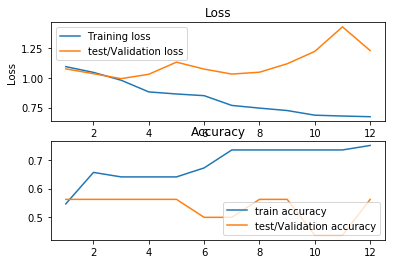

In [0]:
# evaluate the model
acc_on_train(X_train_di,y_train_di,model)
acc_on_test(X_test_di,y_test_di,model)
plot_accuracy_loss(history_di)

In [0]:
#predict
p=model.predict(x=X_test_di)
p.shape
p[0]

array([0.17122951, 0.69816166, 0.13060877], dtype=float32)

In [0]:
# Save the model in h5 format 
model.save("di.h5")

# **PSS**

In [0]:
ytrain_pss = np.asarray(df["PSS_Class"])
encoder = LabelEncoder()
encoder.fit(ytrain_pss)
encoded_Y = encoder.transform(ytrain_pss)
# convert integers to dummy variables (i.e. one hot encoded)
ytrain_pss = np_utils.to_categorical(encoded_Y)

X_train_pss, X_test_pss, y_train_pss, y_test_pss = train_test_split(elmo_train_X, ytrain_pss, test_size=0.2,random_state=42)
print (X_train_pss.shape, y_train_pss.shape)
print (X_test_pss.shape, y_test_pss.shape)

(64, 4495, 1024) (64, 3)
(16, 4495, 1024) (16, 3)


In [0]:
history_pss = model.fit(X_train_pss, y_train_pss, epochs=12,validation_data=(X_test_pss, y_test_pss), batch_size=15)

Train on 64 samples, validate on 16 samples
Epoch 1/12
64/64 [==============================] - 116s 2s/sample - loss: 0.4671 - acc: 0.9219 - mean_absolute_error: 0.1816 - mean_squared_error: 0.0664 - val_loss: 0.4172 - val_acc: 0.8750 - val_mean_absolute_error: 0.1335 - val_mean_squared_error: 0.0719
Epoch 2/12
64/64 [==============================] - 115s 2s/sample - loss: 0.2154 - acc: 0.9375 - mean_absolute_error: 0.0899 - mean_squared_error: 0.0327 - val_loss: 0.5802 - val_acc: 0.8750 - val_mean_absolute_error: 0.0905 - val_mean_squared_error: 0.0807
Epoch 3/12
64/64 [==============================] - 115s 2s/sample - loss: 0.1261 - acc: 0.9688 - mean_absolute_error: 0.0373 - mean_squared_error: 0.0183 - val_loss: 0.7964 - val_acc: 0.8750 - val_mean_absolute_error: 0.0846 - val_mean_squared_error: 0.0829
Epoch 4/12
64/64 [==============================] - 115s 2s/sample - loss: 0.1153 - acc: 0.9844 - mean_absolute_error: 0.0215 - mean_squared_error: 0.0124 - val_loss: 0.8529 - val

CPU times: user 2 µs, sys: 2 µs, total: 4 µs
Wall time: 8.82 µs
Accuracy on trian data: 98.44%
MAE on train data: 1.73%
MSE on train data: 1.03%


CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 8.34 µs
Accuracy on test data: 87.50%
MAE on test data: 8.77%
MSE on test data: 8.18%




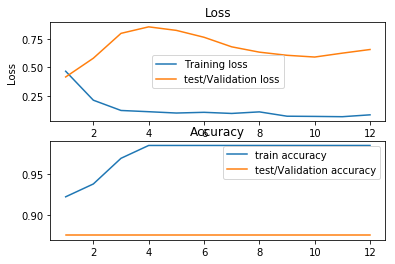

In [0]:
# evaluate the model
acc_on_train(X_train_pss,y_train_pss,model)
acc_on_test(X_test_pss,y_test_pss,model)
plot_accuracy_loss(history_pss)

In [0]:
# Save the model in h5 format 
model.save("pss.h5")

# **GSE**

In [0]:
ytrain_gse = np.asarray(df["GSE_Class"])
encoder = LabelEncoder()
encoder.fit(ytrain_gse)
encoded_Y = encoder.transform(ytrain_gse)
# convert integers to dummy variables (i.e. one hot encoded)
ytrain_gse = np_utils.to_categorical(encoded_Y)

X_train_gse, X_test_gse, y_train_gse, y_test_gse = train_test_split(elmo_train_X, ytrain_gse, test_size=0.2,random_state=42)
print (X_train_gse.shape, y_train_gse.shape)
print (X_test_gse.shape, y_test_gse.shape)

(64, 4495, 1024) (64, 3)
(16, 4495, 1024) (16, 3)


In [0]:
history_gse = model.fit(X_train_gse, y_train_gse, epochs=12,validation_data=(X_test_gse, y_test_gse), batch_size=15)

Train on 64 samples, validate on 16 samples
Epoch 1/12
64/64 [==============================] - 120s 2s/sample - loss: 1.5385 - acc: 0.6875 - mean_absolute_error: 0.2176 - mean_squared_error: 0.2001 - val_loss: 0.6779 - val_acc: 0.7500 - val_mean_absolute_error: 0.2096 - val_mean_squared_error: 0.1349
Epoch 2/12
64/64 [==============================] - 118s 2s/sample - loss: 0.9112 - acc: 0.6875 - mean_absolute_error: 0.2798 - mean_squared_error: 0.1644 - val_loss: 0.6908 - val_acc: 0.7500 - val_mean_absolute_error: 0.3003 - val_mean_squared_error: 0.1295
Epoch 3/12
64/64 [==============================] - 118s 2s/sample - loss: 0.9033 - acc: 0.6875 - mean_absolute_error: 0.3557 - mean_squared_error: 0.1751 - val_loss: 0.7672 - val_acc: 0.7500 - val_mean_absolute_error: 0.3396 - val_mean_squared_error: 0.1447
Epoch 4/12
64/64 [==============================] - 117s 2s/sample - loss: 0.8507 - acc: 0.7344 - mean_absolute_error: 0.3600 - mean_squared_error: 0.1628 - val_loss: 0.7633 - val

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 9.06 µs
Accuracy on trian data: 75.00%
MAE on train data: 24.46%
MSE on train data: 12.33%


CPU times: user 2 µs, sys: 2 µs, total: 4 µs
Wall time: 7.87 µs
Accuracy on test data: 75.00%
MAE on test data: 24.88%
MSE on test data: 12.99%




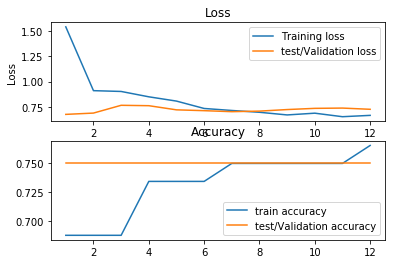

In [0]:
# evaluate the model
acc_on_train(X_train_gse,y_train_gse,model)
acc_on_test(X_test_gse,y_test_gse,model)
plot_accuracy_loss(history_gse)

In [0]:
# Save the model in h5 format 
model.save("gse.h5")

# **Ex**

In [0]:
ytrain_ex = np.asarray(df["Ex_Class"])
encoder = LabelEncoder()
encoder.fit(ytrain_ex)
encoded_Y = encoder.transform(ytrain_ex)
# convert integers to dummy variables (i.e. one hot encoded)
ytrain_ex = np_utils.to_categorical(encoded_Y)

X_train_ex, X_test_ex, y_train_ex, y_test_ex = train_test_split(elmo_train_X, ytrain_ex, test_size=0.2,random_state=42)
print (X_train_ex.shape, y_train_ex.shape)
print (X_test_ex.shape, y_test_ex.shape)

(64, 4495, 1024) (64, 3)
(16, 4495, 1024) (16, 3)


In [0]:
history_ex = model.fit(X_train_ex, y_train_ex, epochs=12,validation_data=(X_test_ex, y_test_ex), batch_size=15)

Train on 64 samples, validate on 16 samples


W0827 10:52:33.243045 139739370510208 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/12
64/64 [==============================] - 238s 4s/sample - loss: 1.0878 - acc: 0.5312 - mean_absolute_error: 0.4420 - mean_squared_error: 0.2199 - val_loss: 1.0583 - val_acc: 0.7500 - val_mean_absolute_error: 0.4345 - val_mean_squared_error: 0.2131
Epoch 2/12
64/64 [==============================] - 235s 4s/sample - loss: 1.0557 - acc: 0.5469 - mean_absolute_error: 0.4337 - mean_squared_error: 0.2127 - val_loss: 1.0096 - val_acc: 0.7500 - val_mean_absolute_error: 0.4189 - val_mean_squared_error: 0.2013
Epoch 3/12
64/64 [==============================] - 237s 4s/sample - loss: 0.9992 - acc: 0.5469 - mean_absolute_error: 0.4169 - mean_squared_error: 0.1999 - val_loss: 0.9632 - val_acc: 0.7500 - val_mean_absolute_error: 0.3926 - val_mean_squared_error: 0.1878
Epoch 4/12
64/64 [==============================] - 235s 4s/sample - loss: 0.9509 - acc: 0.5625 - mean_absolute_error: 0.3922 - mean_squared_error: 0.1900 - val_loss: 0.9317 - val_acc: 0.7500 - val_mean_absolute_error: 0.35

CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 6.91 µs
Accuracy on trian data: 65.62%
MAE on train data: 31.43%
MSE on train data: 15.24%


CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 6.68 µs
Accuracy on test data: 75.00%
MAE on test data: 34.38%
MSE on test data: 19.39%




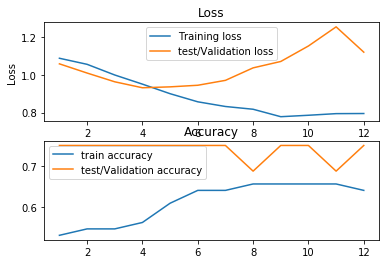

In [0]:
# evaluate the model
acc_on_train(X_train_ex,y_train_ex,model)
acc_on_test(X_test_ex,y_test_ex,model)
plot_accuracy_loss(history_ex)

In [0]:
# Save the model in h5 format 
model.save("ex.h5")

# **A**

In [0]:
ytrain_a = np.asarray(df["A_Class"])
encoder = LabelEncoder()
encoder.fit(ytrain_a)
encoded_Y = encoder.transform(ytrain_a)
# convert integers to dummy variables (i.e. one hot encoded)
ytrain_a = np_utils.to_categorical(encoded_Y)
X_train_a, X_test_a, y_train_a, y_test_a = train_test_split(elmo_train_X, ytrain_a, test_size=0.2,random_state=42)
print (X_train_a.shape, y_train_a.shape)
print (X_test_a.shape, y_test_a.shape)

(64, 4495, 1024) (64, 3)
(16, 4495, 1024) (16, 3)


In [0]:
history_a = model.fit(X_train_a, y_train_a, epochs=12,validation_data=(X_test_a, y_test_a), batch_size=15)

Train on 64 samples, validate on 16 samples
Epoch 1/12
64/64 [==============================] - 236s 4s/sample - loss: 1.2267 - acc: 0.4844 - mean_absolute_error: 0.3811 - mean_squared_error: 0.2169 - val_loss: 1.1712 - val_acc: 0.4375 - val_mean_absolute_error: 0.4125 - val_mean_squared_error: 0.2336
Epoch 2/12
64/64 [==============================] - 234s 4s/sample - loss: 0.9950 - acc: 0.4844 - mean_absolute_error: 0.3720 - mean_squared_error: 0.1978 - val_loss: 0.9480 - val_acc: 0.3750 - val_mean_absolute_error: 0.3945 - val_mean_squared_error: 0.1945
Epoch 3/12
64/64 [==============================] - 237s 4s/sample - loss: 0.8557 - acc: 0.5312 - mean_absolute_error: 0.3643 - mean_squared_error: 0.1766 - val_loss: 0.8643 - val_acc: 0.5625 - val_mean_absolute_error: 0.3656 - val_mean_squared_error: 0.1788
Epoch 4/12
64/64 [==============================] - 235s 4s/sample - loss: 0.7477 - acc: 0.5938 - mean_absolute_error: 0.3210 - mean_squared_error: 0.1580 - val_loss: 0.9043 - val

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 6.2 µs
Accuracy on trian data: 62.50%
MAE on train data: 28.06%
MSE on train data: 13.69%


CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 7.15 µs
Accuracy on test data: 56.25%
MAE on test data: 34.32%
MSE on test data: 19.88%




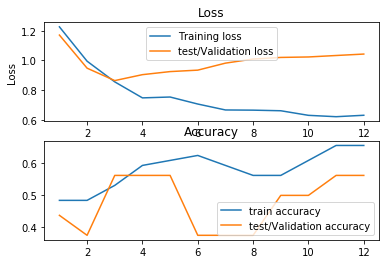

In [0]:
# evaluate the model
acc_on_train(X_train_a,y_train_a,model)
acc_on_test(X_test_a,y_test_a,model)
plot_accuracy_loss(history_a)

In [0]:
# Save the model in h5 format 
model.save("a.h5")

# **C**

In [0]:
ytrain_c = np.asarray(df["C_Class"])
encoder = LabelEncoder()
encoder.fit(ytrain_c)
encoded_Y = encoder.transform(ytrain_c)
# convert integers to dummy variables (i.e. one hot encoded)
ytrain_c = np_utils.to_categorical(encoded_Y)

X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(elmo_train_X, ytrain_c, test_size=0.2,random_state=42)
print (X_train_c.shape, y_train_c.shape)
print (X_test_c.shape, y_test_c.shape)

(64, 4495, 1024) (64, 3)
(16, 4495, 1024) (16, 3)


In [0]:
history_c = model.fit(X_train_c, y_train_c, epochs=12,validation_data=(X_test_c, y_test_c), batch_size=15)

Train on 64 samples, validate on 16 samples


W0827 14:13:38.726634 140056909944704 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/12
64/64 [==============================] - 235s 4s/sample - loss: 1.0955 - acc: 0.3125 - mean_absolute_error: 0.4437 - mean_squared_error: 0.2215 - val_loss: 1.0765 - val_acc: 0.5625 - val_mean_absolute_error: 0.4394 - val_mean_squared_error: 0.2174
Epoch 2/12
64/64 [==============================] - 227s 4s/sample - loss: 1.0552 - acc: 0.5938 - mean_absolute_error: 0.4343 - mean_squared_error: 0.2126 - val_loss: 1.0424 - val_acc: 0.5000 - val_mean_absolute_error: 0.4306 - val_mean_squared_error: 0.2107
Epoch 3/12
64/64 [==============================] - 229s 4s/sample - loss: 0.9912 - acc: 0.5781 - mean_absolute_error: 0.4177 - mean_squared_error: 0.1991 - val_loss: 1.0036 - val_acc: 0.5000 - val_mean_absolute_error: 0.4153 - val_mean_squared_error: 0.2058
Epoch 4/12
64/64 [==============================] - 226s 4s/sample - loss: 0.8816 - acc: 0.5938 - mean_absolute_error: 0.3830 - mean_squared_error: 0.1773 - val_loss: 0.9822 - val_acc: 0.5000 - val_mean_absolute_error: 0.38

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.68 µs
Accuracy on trian data: 65.62%
MAE on train data: 28.77%
MSE on train data: 13.94%


CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 6.44 µs
Accuracy on test data: 62.50%
MAE on test data: 34.67%
MSE on test data: 21.49%




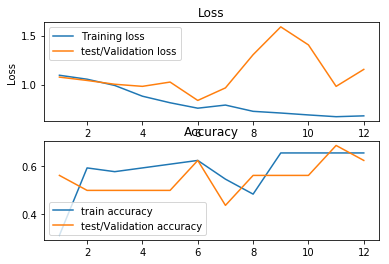

In [0]:
# evaluate the model
acc_on_train(X_train_c,y_train_c,model)
acc_on_test(X_test_c,y_test_c,model)
plot_accuracy_loss(history_c)

In [0]:
# Save the model in h5 format 
model.save("c.h5")

# **E**

In [0]:
ytrain_e = np.asarray(df["E_Class"])
encoder = LabelEncoder()
encoder.fit(ytrain_e)
encoded_Y = encoder.transform(ytrain_e)
# convert integers to dummy variables (i.e. one hot encoded)
ytrain_e = np_utils.to_categorical(encoded_Y)
X_train_e, X_test_e, y_train_e, y_test_e = train_test_split(elmo_train_X, ytrain_e, test_size=0.2,random_state=42)
print (X_train_e.shape, y_train_e.shape)
print (X_test_e.shape, y_test_e.shape)

(64, 4495, 1024) (64, 3)
(16, 4495, 1024) (16, 3)


In [0]:
history_e = model.fit(X_train_e, y_train_e, epochs=12,validation_data=(X_test_e, y_test_e), batch_size=15)

Train on 64 samples, validate on 16 samples
Epoch 1/12
64/64 [==============================] - 228s 4s/sample - loss: 1.7091 - acc: 0.5156 - mean_absolute_error: 0.4265 - mean_squared_error: 0.2753 - val_loss: 1.5417 - val_acc: 0.3750 - val_mean_absolute_error: 0.4259 - val_mean_squared_error: 0.2827
Epoch 2/12
64/64 [==============================] - 226s 4s/sample - loss: 1.4137 - acc: 0.4688 - mean_absolute_error: 0.4401 - mean_squared_error: 0.2722 - val_loss: 1.2442 - val_acc: 0.4375 - val_mean_absolute_error: 0.4180 - val_mean_squared_error: 0.2493
Epoch 3/12
64/64 [==============================] - 226s 4s/sample - loss: 1.0481 - acc: 0.5625 - mean_absolute_error: 0.3903 - mean_squared_error: 0.2075 - val_loss: 1.0949 - val_acc: 0.4375 - val_mean_absolute_error: 0.4202 - val_mean_squared_error: 0.2202
Epoch 4/12
64/64 [==============================] - 229s 4s/sample - loss: 0.9790 - acc: 0.5625 - mean_absolute_error: 0.3862 - mean_squared_error: 0.1943 - val_loss: 1.0717 - val

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 18.6 µs
Accuracy on trian data: 67.19%
MAE on train data: 32.30%
MSE on train data: 15.37%


CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 7.63 µs
Accuracy on test data: 43.75%
MAE on test data: 40.58%
MSE on test data: 22.36%




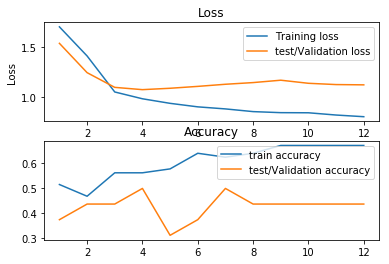

In [0]:
# evaluate the model
acc_on_train(X_train_e,y_train_e,model)
acc_on_test(X_test_e,y_test_e,model)
plot_accuracy_loss(history_e)

In [0]:
# Save the model in h5 format 
model.save("e.h5")

# **O**

In [0]:
ytrain_o = np.asarray(df["O_Class"])
encoder = LabelEncoder()
encoder.fit(ytrain_o)
encoded_Y = encoder.transform(ytrain_o)
# convert integers to dummy variables (i.e. one hot encoded)
ytrain_o = np_utils.to_categorical(encoded_Y)
X_train_o, X_test_o, y_train_o, y_test_o = train_test_split(elmo_train_X, ytrain_o, test_size=0.2,random_state=42)
print (X_train_o.shape, y_train_o.shape)
print (X_test_o.shape, y_test_o.shape)

(64, 4495, 1024) (64, 3)
(16, 4495, 1024) (16, 3)


In [0]:
history_o = model.fit(X_train_o, y_train_o, epochs=12,validation_data=(X_test_o, y_test_o), batch_size=15)

Train on 64 samples, validate on 16 samples
Epoch 1/12
64/64 [==============================] - 231s 4s/sample - loss: 0.8641 - acc: 0.7344 - mean_absolute_error: 0.3286 - mean_squared_error: 0.1619 - val_loss: 0.5608 - val_acc: 0.8750 - val_mean_absolute_error: 0.2680 - val_mean_squared_error: 0.0994
Epoch 2/12
64/64 [==============================] - 231s 4s/sample - loss: 0.7773 - acc: 0.7344 - mean_absolute_error: 0.2971 - mean_squared_error: 0.1480 - val_loss: 0.4674 - val_acc: 0.8750 - val_mean_absolute_error: 0.2152 - val_mean_squared_error: 0.0805
Epoch 3/12
64/64 [==============================] - 224s 4s/sample - loss: 0.6171 - acc: 0.7969 - mean_absolute_error: 0.2439 - mean_squared_error: 0.1165 - val_loss: 0.4181 - val_acc: 0.8750 - val_mean_absolute_error: 0.1813 - val_mean_squared_error: 0.0743
Epoch 4/12
64/64 [==============================] - 224s 3s/sample - loss: 0.5388 - acc: 0.8125 - mean_absolute_error: 0.2011 - mean_squared_error: 0.1038 - val_loss: 0.4004 - val

CPU times: user 18 µs, sys: 4 µs, total: 22 µs
Wall time: 30.5 µs
Accuracy on trian data: 81.25%
MAE on train data: 18.19%
MSE on train data: 9.16%


CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 7.39 µs
Accuracy on test data: 87.50%
MAE on test data: 18.35%
MSE on test data: 7.66%




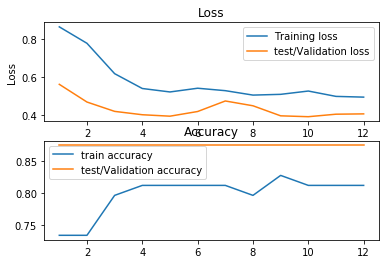

In [0]:
# evaluate the model
acc_on_train(X_train_o,y_train_o,model)
acc_on_test(X_test_o,y_test_o,model)
plot_accuracy_loss(history_o)

In [0]:
# Save the model in h5 format 
model.save("o.h5")